# Sensor Body Frame Registration 3 (cont'd)

Confirming the quaternion registration method to re-orient the rotation signals.

## Showing the Boot Orientation Results

For the Dec 30th session, plotting the sensor and boot frame orientations against eachother.

In [1]:
from domain.sessions import Session_2023_12_30

In [2]:
session_2023_12_30 = Session_2023_12_30(prototype_sigs=True)

Showing the static registrations as "tared" orientations:

In [3]:
from utilities.quat import quatToEuler

euler1 = quatToEuler(session_2023_12_30.tile.static_registration.registrations[0].avg_quat)
euler2 = quatToEuler(session_2023_12_30.tile.static_registration.registrations[1].avg_quat)

print(euler1)
print(euler2)

[-97.71180377  57.7406064  109.02372385]
[-93.18363617  56.77907148  99.67208929]


In [4]:
import matplotlib.pyplot as plt
import numpy as np
from utilities.sig_proc_np import makeContinuousRange3dof
from models.tile import Tile

def plotTileBootOrientationWithStillZones(tile: Tile, r=[0, -1]):
    def addStillZones(ax, t, ranges, r, _color='green'):
        for range in ranges:
            if tile.time[range[0]] < tile.time[r[0]] or tile.time[range[1]] > tile.time[r[1]]: 
                continue
            ax.axvspan(t[range[0]], t[range[1]], color=_color, alpha=0.25)

    def addHorizontalLines(ax):
        ax.axhline(y=0, color='k', linestyle='--')
        ax.axhline(y=90, color='k', linestyle='--')
        ax.axhline(y=180, color='k', linestyle='--')
        ax.axhline(y=-90, color='k', linestyle='--')
        ax.axhline(y=-180, color='k', linestyle='--')


    fine_rs = [r for r in tile.static_registration.ranges if r is not None]
    coarse_rs = tile.static_registration.coarse_ranges
    t = tile.time[r[0]:r[1]]


    boot_quat = tile.boot_quat[r[0]:r[1], :]
    boot_quat_euler = np.apply_along_axis(quatToEuler, 1, boot_quat)
    # boot_quat_euler = makeContinuousRange3dof(boot_quat_euler, fix_0=True, fix_1=True, fix_2=True)

    sensor_quat = tile.imu.quat[r[0]:r[1], :]
    sensor_euler = np.apply_along_axis(quatToEuler, 1, sensor_quat)
    # sensor_euler = makeContinuousRange3dof(sensor_euler, fix_0=True, fix_1=True, fix_2=True)

    boot_direct_euler = tile.boot_rotated_euler[r[0]:r[1], :]
    # boot_direct_euler = makeContinuousRange3dof(boot_direct_euler, fix_0=True, fix_1=True, fix_2=True)

    boot_rotM_euler = tile.boot_rotM_euler[r[0]:r[1], :]
    # boot_rotM_euler = makeContinuousRange3dof(boot_rotM_euler, fix_0=True, fix_1=True, fix_2=True)


    plt.rc('lines', linewidth=1)
    fig, ax = plt.subplots(4, figsize=(15, 10))

    ax[0].plot(t, tile.alt_lpf[r[0]:r[1]])
    addStillZones(ax[0], tile.time, fine_rs, r)
    addStillZones(ax[0], tile.time, coarse_rs, r, 'red')
    ax[0].set_title('All Tile Altitude with Still Zones', wrap=True)

    ax[1].plot(t, sensor_euler[:, 0], label='sensor')
    ax[1].plot(t, boot_quat_euler[:, 0], label='boot_quat_euler')
    ax[1].plot(t, boot_direct_euler[:, 0], label='boot_direct_euler')
    ax[1].plot(t, boot_rotM_euler[:, 0], label='boot_rotM_euler')
    addStillZones(ax[1], tile.time, fine_rs, r)
    addStillZones(ax[1], tile.time, coarse_rs, r, 'red')
    addHorizontalLines(ax[1])
    ax[1].set_title('All Tile Roll with Still Zones', wrap=True)
    ax[1].legend()

    ax[2].plot(t, sensor_euler[:, 1], label='sensor')
    ax[2].plot(t, boot_quat_euler[:, 1], label='boot_quat_euler')
    ax[2].plot(t, boot_direct_euler[:, 1], label='boot_direct_euler')
    ax[2].plot(t, boot_rotM_euler[:, 1], label='boot_rotM_euler')
    addStillZones(ax[2], tile.time, fine_rs, r)
    addStillZones(ax[2], tile.time, coarse_rs, r, 'red')
    addHorizontalLines(ax[2])
    ax[2].set_title('All Tile Pitch with Still Zones', wrap=True)
    ax[2].legend()

    ax[3].plot(t, sensor_euler[:, 2], label='sensor')
    ax[3].plot(t, boot_quat_euler[:, 2], label='boot_quat_euler')
    ax[3].plot(t, boot_direct_euler[:, 2], label='boot_direct_euler')
    ax[3].plot(t, boot_rotM_euler[:, 2], label='boot_rotM_euler')
    addStillZones(ax[3], tile.time, fine_rs, r)
    addStillZones(ax[3], tile.time, coarse_rs, r, 'red')
    addHorizontalLines(ax[3])
    ax[3].set_title('All Tile Yaw with Still Zones', wrap=True)
    ax[3].legend()

    plt.tight_layout()
    plt.show()
    return fig

def plotAllTileBootOrientationsForRegistationZones(tile: Tile, r=[0, -1]):
    _ = plotTileBootOrientationWithStillZones(tile, r=r)
    brackets = [[r[1]+4000, r[1]+10000] for r in tile.static_registration.ranges]
    _ = [plotTileBootOrientationWithStillZones(tile, r=bracket) for bracket in brackets]

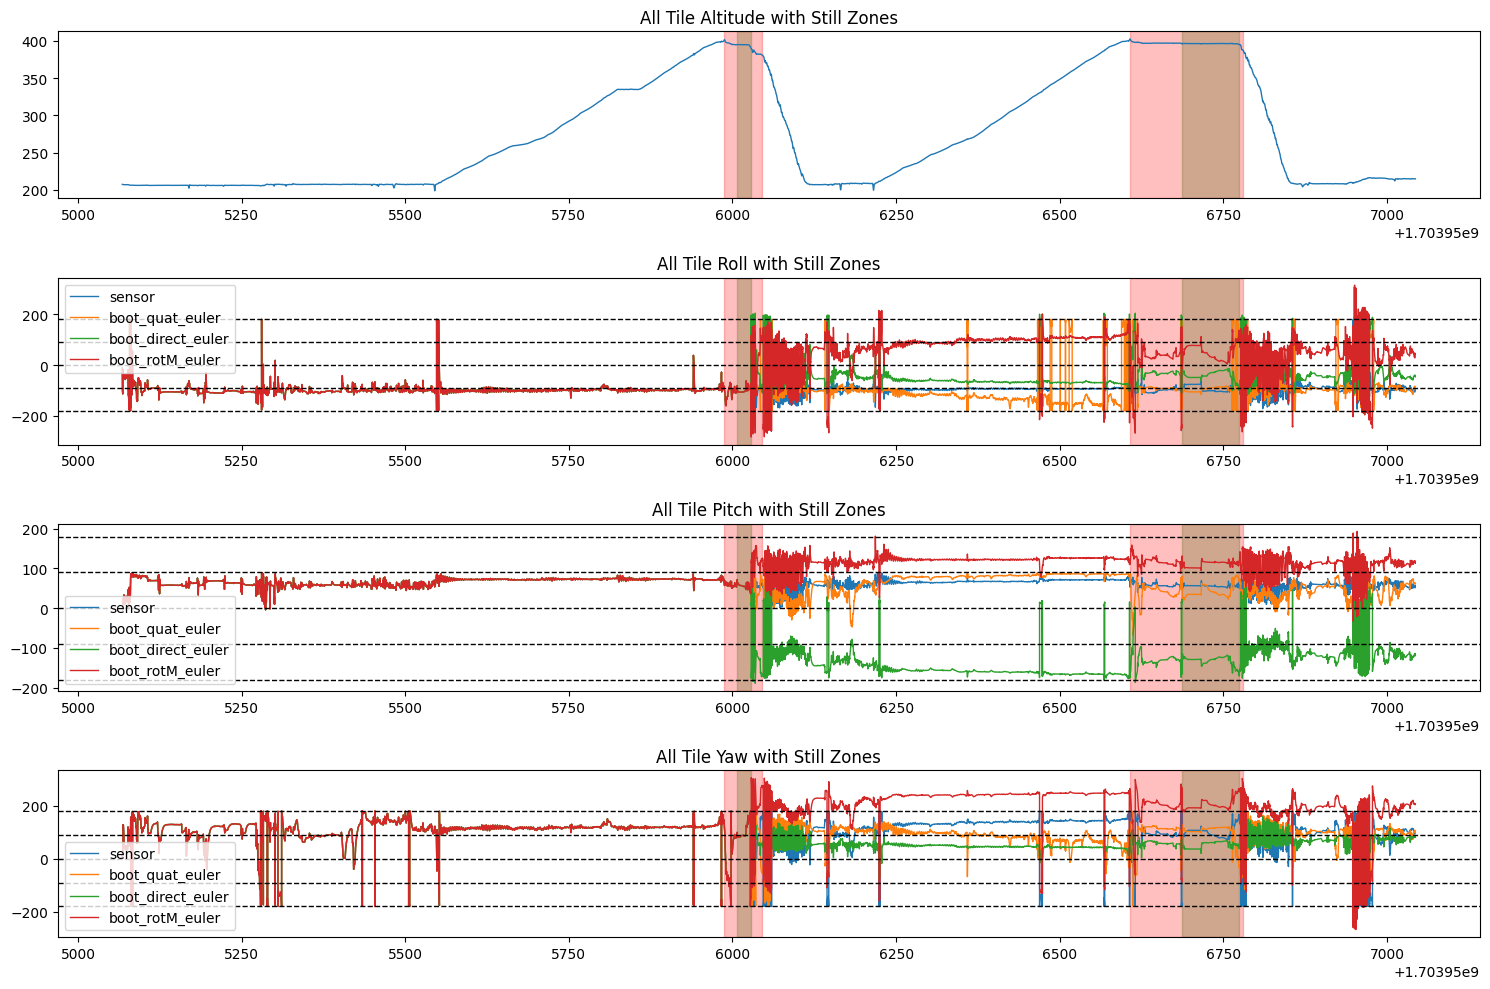

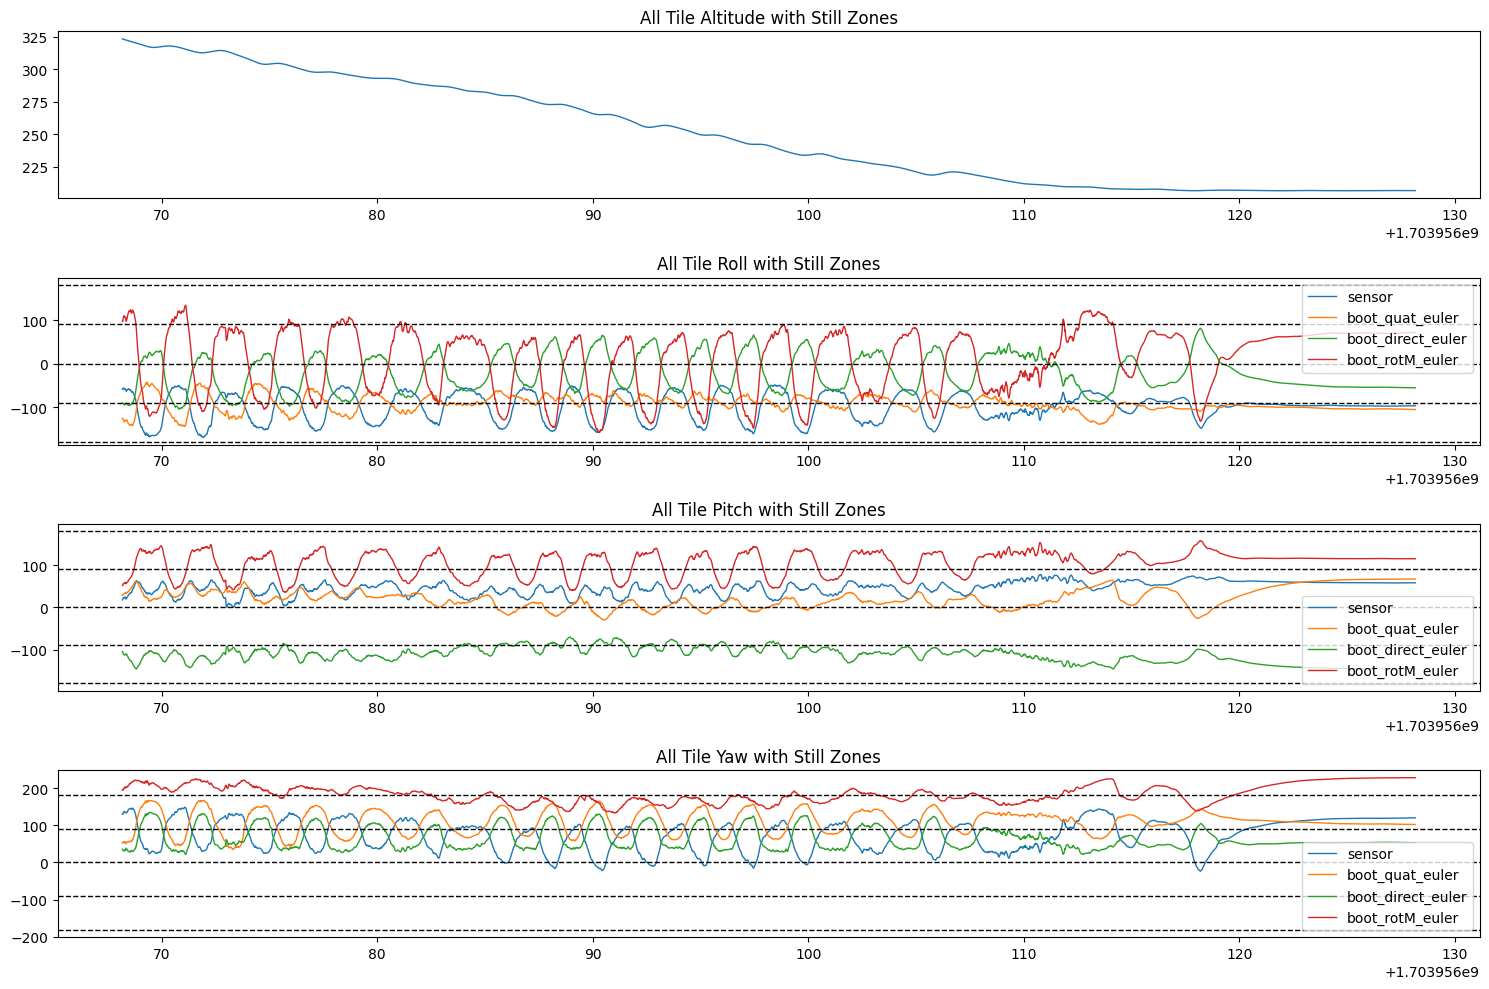

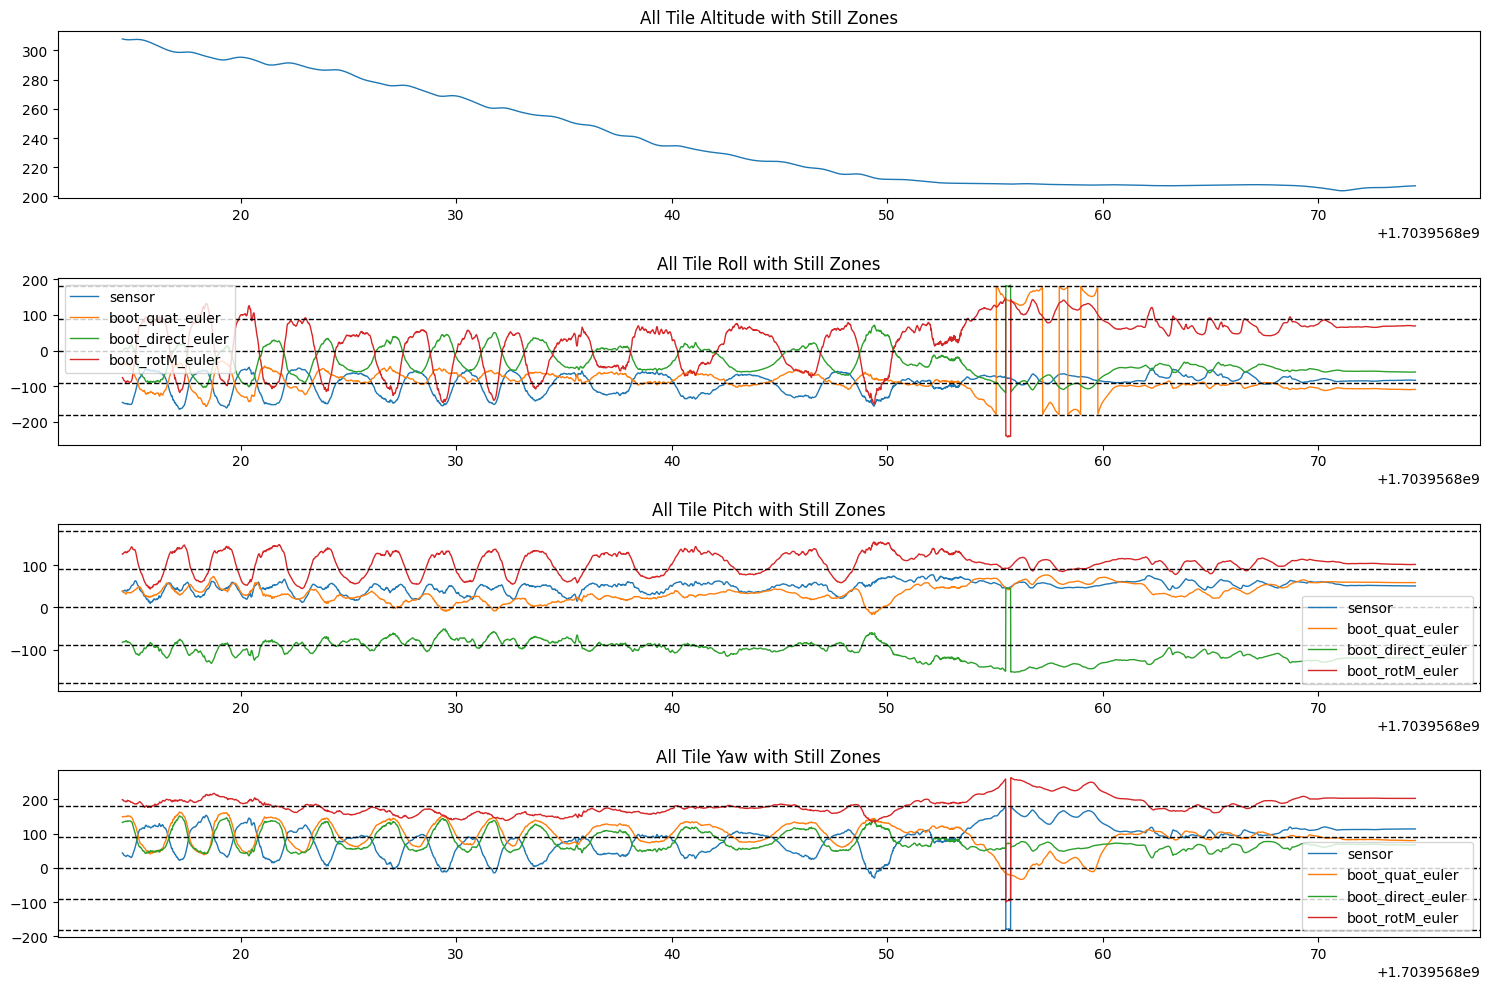

In [5]:
plotAllTileBootOrientationsForRegistationZones(session_2023_12_30.tile)

## Matching Ranges to the Correct Axes

- roll +/- [45-60] centred about 0
  - represents edge angle
- pitch +/- [0-60] signal stays in one sign of axis
  - represents knee bending
- yaw +/- 180, during turns +/- [45-60] not necessarily centred about 0
  - represents heading

### Problem with the Euler Signal Representation

The euler signals don't quite make sense, a hypothesis is because the ZYX cardan sequence is putting the angles into the innaccurate range where beta > 40deg. The orientation quaternion doesn't suffer from this problem, so it'll make sense to do some tests with the tile in known positions to confirm the best sequence to represent the euler angles when worn in the skiing sessions.